# Summarization

## Architecture

A central question for building a summarizer is how to pass your documents into the LLM's context window. Two common approaches for this are:

`Stuff`: Simply "stuff" all your documents into a single prompt. This is the simplest approach (see here for more on the create_stuff_documents_chain constructor, which is used for this method).

`Map-reduce`: Summarize each document on its own in a "map" step and then "reduce" the summaries into a final summary (see here for more on the MapReduceDocumentsChain, which is used for this method).

<img src="https://python.langchain.com/v0.2/assets/images/summarization_use_case_2-f2a4d5d60980a79140085fb7f8043217.png" alt="indexing" width="900"/>

## Setup

In [1]:
import os

os.chdir("../../../")

In [2]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()

True

## Quickstart

In [3]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

## Stuff: summarize in a single LLM call

The chain will take a list of documents, insert them all into a prompt, and pass that prompt to an LLM:

In [5]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.llm import LLMChain
from langchain_core.prompts import ChatPromptTemplate

# Define prompt
prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

# Instantiate chain
chain = create_stuff_documents_chain(llm, prompt)

# Invoke chain
result = chain.invoke({"context": docs})
print(result)

The article "LLM Powered Autonomous Agents" by Lilian Weng discusses the development and functionality of autonomous agents that leverage large language models (LLMs) as their core controllers. It provides an overview of the agent system, detailing three main components: planning, memory, and tool use.

1. **Planning**: This involves task decomposition where agents break down complex tasks into manageable subgoals and utilize self-reflection to improve their decision-making by learning from past actions.
   
2. **Memory**: Two types of memory are discussed: short-term memory (in-context learning) and long-term memory (using external vector stores for retrieval), both aiding the agent in retaining and recalling information effectively.

3. **Tool Use**: The article highlights the importance of equipping LLMs with external tools to enhance their capabilities. Various frameworks, such as MRKL and HuggingGPT, are mentioned, showcasing how LLMs can interact with APIs and perform complex tas

In [6]:
# streaming
for token in chain.stream({"context": docs}):
    print(token, end="|")

|The| article| "|LL|M| Powered| Autonomous| Agents|"| by| Lil|ian| W|eng| discusses| the| concept| of| using| large| language| models| (|LL|Ms|)| as| the| core| controllers| for| autonomous| agents|.| It| outlines| a| system| overview| that| includes| three| main| components|:| planning|,| memory|,| and| tool| use|.| 

|1|.| **|Planning|**|:| Autonomous| agents| break| down| complex| tasks| into| smaller| sub|go|als| and| reflect| on| past| actions| to| improve| future| decision|-making|.| Techniques| like| Chain| of| Thought| (|Co|T|)| and| Tree| of| Thoughts| (|To|T|)| are| highlighted| for| task| decomposition|.

|2|.| **|Memory|**|:| The| article| categor|izes| memory| into| short|-term| (|in|-context| learning|)| and| long|-term| (|external| vector| storage|)| types|.| It| emphasizes| the| importance| of| maximum| inner| product| search| (|M|IPS|)| for| efficient| information| retrieval|.

|3|.| **|Tool| Use|**|:| The| ability| of| L|LM|s| to| interact| with| external| APIs| and| 

## Map-Reduce: summarize long texts via parallelization

Let's unpack the map reduce approach. For this, we'll first map each document to an individual summary using an LLM. Then we'll reduce or consolidate those summaries into a single global summary.

### Map

In [7]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

map_prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

map_chain = map_prompt | llm | StrOutputParser()

### Reduce

In [8]:
reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes.
"""

reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

reduce_chain = reduce_prompt | llm | StrOutputParser()

### Orchestration via LangGraph

In [9]:
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)
print(f"Generated {len(split_docs)} documents.")

Created a chunk of size 1003, which is longer than the specified 1000


Generated 14 documents.


In [15]:
import operator
from typing import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

token_max = 1000


def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)


# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str
    

# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str
    

# Here we generate a summary, given a document
async def generate_summary(state: SummaryState):
    response = await map_chain.ainvoke(state["content"])
    return {"summaries": [response]}


# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]


# Add node to collapse summaries
async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, reduce_chain.ainvoke))

    return {"collapsed_summaries": results}


def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }
    

# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await reduce_chain.ainvoke(state["collapsed_summaries"])
    return {"final_summary": response}


# This represents a conditional edge in the graph that determines
# if we should collapse the summaries or not
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"

In [16]:
# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

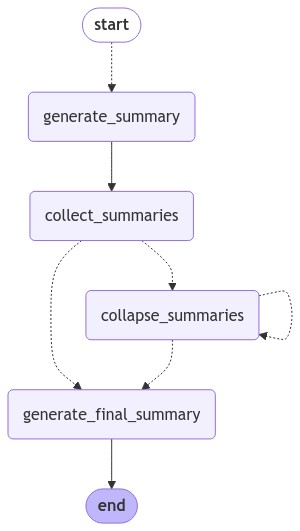

In [17]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [18]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['collect_summaries']
['collapse_summaries']
['generate_final_summary']


In [19]:
print(step)

{'generate_final_summary': {'final_summary': 'The consolidated summary of the main themes from the provided documents focuses on the advancements and methodologies in the development of large language model (LLM)-powered autonomous agents, highlighting several key areas:\n\n1. **Core Components of Autonomous Agents**: LLMs serve as central controllers, incorporating essential elements like Planning, Memory, and Tool Use. Techniques such as Chain of Thought (CoT) and Tree of Thoughts (ToT) facilitate task decomposition, while self-reflection enhances decision-making through iterative learning.\n\n2. **Methodologies for Improvement**: Various techniques, including Chain of Hindsight (CoH) and Algorithm Distillation (AD), aim to refine model outputs by leveraging historical context and human feedback. These methodologies emphasize self-improvement and efficient learning trajectories.\n\n3. **Reinforcement Learning and Memory**: The integration of memory types—sensory, short-term, and long